<a href="https://colab.research.google.com/github/Hing-9/popup_store/blob/main/KcElectra_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.0/7.0 MB 95.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7.8/7.8 MB 88.2 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 224.5/224.5 kB 24.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Graduation-Thesis/NER

Mounted at /content/drive
/content/drive/MyDrive/Graduation-Thesis/NER


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.backends.cudnn as cudnn
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
torch.manual_seed(98)
torch.cuda.manual_seed(98)
torch.cuda.manual_seed_all(98)
cudnn.benchmark = False
cudnn.deterministic = True

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
def file_to_data(path) :
    with open(path, 'r', encoding='UTF-8') as f :
        return json.load(f)['data']

def data_only_org(data) :
    ner_sentences = []
    for sentence in data :
        if sentence['ner'] : # NER ÏûàÎäî Îç∞Ïù¥ÌÑ∞ Î∞úÍ≤¨
            tags = sentence['ner']['tags']
            org_flag = False
            for tag in tags :
                if tag['tag'] == 'ORG' :
                    org_flag = True
                    break
            if org_flag :
                ner_sentences.append(sentence)
    return ner_sentences

In [ ]:
data_ÏòÅÌïú = file_to_data('./·Ñã·Öµ·ÜØ·Ñâ·Ö°·Üº·Ñâ·Ö¢·Üº·Ñí·Ö™·ÜØ·ÑÜ·Öµ·Üæ·ÑÄ·ÖÆ·Ñã·Ö•·Ñé·Ö¶_·Ñã·Öß·Üº·Ñí·Ö°·Ü´_train_set.json')
data_ÌïúÏòÅ = file_to_data('./·Ñã·Öµ·ÜØ·Ñâ·Ö°·Üº·Ñâ·Ö¢·Üº·Ñí·Ö™·ÜØ·ÑÜ·Öµ·Üæ·ÑÄ·ÖÆ·Ñã·Ö•·Ñé·Ö¶_ÌïúÏòÅ_train_set.json')

In [ ]:
# Îç∞Ïù¥ÌÑ∞ Í≤∞Ìï©
data = data_ÏòÅÌïú.copy()
data.extend(data_ÌïúÏòÅ.copy())

print(f'{len(data)} = {len(data_ÏòÅÌïú)} + {len(data_ÌïúÏòÅ)}')

assert len(data) == len(data_ÏòÅÌïú)+len(data_ÌïúÏòÅ)

2400307 = 1200307 + 1200000


In [ ]:
print(f'Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò : '+str(len(data)))
data = data_only_org(data)
print(f'NERÏóê ORGÍ∞Ä Ìè¨Ìï®Îêú Îç∞Ïù¥ÌÑ∞ Í∞úÏàò : '+str(len(data)))

Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò : 2400307
NERÏóê ORGÍ∞Ä Ìè¨Ìï®Îêú Îç∞Ïù¥ÌÑ∞ Í∞úÏàò : 30244


In [ ]:
data[0]

{'sn': 'ECOAR2T00367',
 'data_set': 'ÏùºÏÉÅÏÉùÌôúÎ∞èÍµ¨Ïñ¥Ï≤¥',
 'domain': 'Ìï¥Ïô∏Í≥†Í∞ùÍ≥ºÏùòÏ±ÑÌåÖ',
 'subdomain': 'ÏàôÎ∞ï,ÏùåÏãùÏ†ê',
 'en_original': 'I am a professor at BBB1.',
 'en': 'I am a professor at BBB1.',
 'mt': 'Ï†ÄÎäî BBB1Ïùò ÍµêÏàòÏûÖÎãàÎã§.',
 'ko': 'Ï†ÄÎäî BBB1Ïùò ÍµêÏàòÏûÖÎãàÎã§.',
 'source_language': 'en',
 'target_language': 'ko',
 'word_count_ko': 3.0,
 'word_count_en': 6.0,
 'word_ratio': 0.5,
 'file_name': 'Ìï¥Ïô∏Í≥†Í∞ùÍ≥ºÏùòÏ±ÑÌåÖ_ÏàôÎ∞ï,ÏùåÏãùÏ†ê.xlsx',
 'source': 'ÌÅ¨ÎùºÏö∞Îìú ÏÜåÏã±',
 'license': 'open',
 'style': 'Íµ¨Ïñ¥Ï≤¥',
 'included_unknown_words': False,
 'ner': {'text': 'Ï†ÄÎäî <ORG>BBB1Ïùò</ORG> ÍµêÏàòÏûÖÎãàÎã§.',
  'tags': [{'tag': 'ORG', 'value': 'BBB1Ïùò', 'position': '[3, 8]'}]}}

In [ ]:
# # Ïù¥Í±∞Îäî Ïã§ÌñâÌï¥Î≥º ÌïÑÏöîÎäî ÏóÜÏùå!!
# def kind_of_ner_tags(data) :
#     result = []
#     for sentence in data :
#         tags = sentence['ner']['tags']
#         for tag in tags :
#             result.append(tag['tag'])
    
#     result = list(set(result))
#     return result

# def value_for_tag(find_tag, data) :
#     result = []
#     MAX_CNT = 10
#     cnt = 0

#     for sentence in data :
#         tags = sentence['ner']['tags']
#         for tag in tags :
#             if tag['tag'] == find_tag :
#                 result.append(tag['value'])
#                 cnt += 1
        
#         if cnt >= MAX_CNT :
#                 break;
    
#     return result


# tags = kind_of_ner_tags(data)
# print(f'Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏóêÏÑú Í≤ÄÏ∂úÎêú NER TAGS : {tags}')
# print()

# for tag in tags :
#     print(f'==== TAG : {tag}====')
#     print(value_for_tag(tag, data))

In [ ]:
# # ÌòπÏãúÎÇò.. ÌåùÏóÖÏù¥ Îì§Ïñ¥Í∞Ñ Îç∞Ïù¥ÌÑ∞Î•º Ï∂îÏ∂úÌï¥Î≥¥Ïûê
# def find_popup(data) : 
#     result = []
#     for sentence in data :
#         if 'ÌåùÏóÖ' in sentence['ko'] :
#             result.append(sentence['ko'])
#         # elif 'Ïä§ÌÜ†Ïñ¥' in sentence['ko'] :
#         #     result.append(sentence['ko'])
#     return result

# find_popup(data)

In [ ]:
# ORG ÌÉúÍ∑∏Ïóê Î∏åÎûúÎìúÎ™ÖÏùÑ ÎÑ£Ïñ¥ ÌïôÏäµÏãúÌÇ§ÎäîÍ≤å Ï†ïÎãπÌï¥Î≥¥ÏûÑ.
# Î∏åÎûúÎìúÎ™ÖÏùÄ ÏÜåÏÉÅÍ≥µÏù∏ Îç∞Ïù¥ÌÑ∞
brand_data = pd.read_csv('./ÏÜåÏÉÅÍ≥µÏù∏ÏãúÏû•ÏßÑÌù•Í≥µÎã®_ÏÉÅÍ∞Ä(ÏÉÅÍ∂å)Ï†ïÎ≥¥_ÏÑúÏö∏_202212.csv', encoding='UTF-8')
brand_names = brand_data['ÏÉÅÌò∏Î™Ö'].values

In [ ]:
# ÎûúÎç§ÌïòÍ≤å Î∏åÎûúÎìúÎ™ÖÏùÑ ÏûÖÎ†•
rnd_idx = random.randrange(0, len(brand_names))
brand_names[rnd_idx]

'ÍπåÏÇ¨Î∏åÎùºÏßàÍ∑∏Î¶¥'

In [ ]:
def random_brand_transfer(data) :
    tmp_data = data.copy()

    tokens_arr = []
    tags_arr  = []

    for idx, sentence in enumerate(tmp_data) :

        # ÏúÑÏóêÏÑú Îç∞Ïù¥ÌÑ∞Î•º ÌïúÎ≤à Í±∏Î†ÄÎã§.
        # NER ÌÉúÍ∑∏Í∞Ä ÏûàÍ≥†, ORG ÌÉúÍ∑∏Í∞Ä ÏûàÎäî Í≤ÉÎì§Î°ú!
        
        tags = sentence['ner']['tags']
        position_arr = []

        # ÌÉúÍ∑∏ ÏúÑÏπòÎ•º ÌååÏïÖÌïúÎã§.
        for tag in tags :

            if tag['tag'] == 'ORG' :
                positions = tag['position'][1:-1].split(',')
                start_index = int(positions[0])
                end_index = int(positions[1])

                index_arr = []
                index_arr.append(start_index)
                index_arr.append(end_index)
                position_arr.append(index_arr)
        
        # ÎÇ¥Î¶ºÏ∞®ÏàúÏúºÎ°ú Ï†ïÎ†¨
        position_arr.sort(reverse=True)
        new_sentence = sentence['ko']
        for idx_small, position in enumerate(position_arr) :
            
            # Î∏åÎûúÎìú Ïù¥Î¶Ñ ÎûúÎç§ Ï∂îÏ∂ú Î∞è ÏÑ∏ÌåÖ
            rnd_idx = random.randrange(0, len(brand_names))
            chg_org = brand_names[rnd_idx]

            new_sentence = new_sentence[:position[0]] + chg_org + new_sentence[position[1]:]

            # Ïù∏Îç±Ïä§ Ï¶ùÍ∞ÄÎ∂Ñ
            indeCrease = len(chg_org) - (position[1]-position[0])

            # Ïù∏Îç±Ïä§ Ïû¨ÏÑ§Ï†ï
            position[1] += indeCrease
            for pre_position in position_arr[:idx_small] :
                pre_position[0] += indeCrease
                pre_position[1] += indeCrease

        # if idx == 26805 :
        #     print(sentence['ko'])
        #     print(new_sentence)
            
        #     for word_pos in position_arr :
        #         print(new_sentence[word_pos[0]:word_pos[1]])

        # tokenÍ≥º tag ÏÑ∏ÌåÖ ÏãúÏûë
        new_sentence = new_sentence.replace(' ', '_')
        tokens_sentence = list(new_sentence)
        tags_sentence = []
        for i in range(len(tokens_sentence)) :
            tags_sentence.append('O')
        
        for position in position_arr :
            for i in range(position[0], position[1]) :
               
                if i == position[0] :
                   tag_nm = 'B-ORG'
                else :
                    tag_nm = 'I-ORG'
               
                tags_sentence[i] = tag_nm

        # if idx == 26805 :
        #     print(tokens_sentence)
        #     print(tags_sentence)

        tokens_arr.append(tokens_sentence)
        tags_arr.append(tags_sentence)

    return tokens_arr, tags_arr

texts, tags = random_brand_transfer(data)

len(texts)
len(tags)

30244

In [ ]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

for i, tag in enumerate(unique_tags):
    print(tag)  # ÌïôÏäµÏùÑ ÏúÑÌïú label listÎ•º ÌôïÏù∏

B-ORG
O
I-ORG


## EDA

Text(0, 0.5, 'Probability')

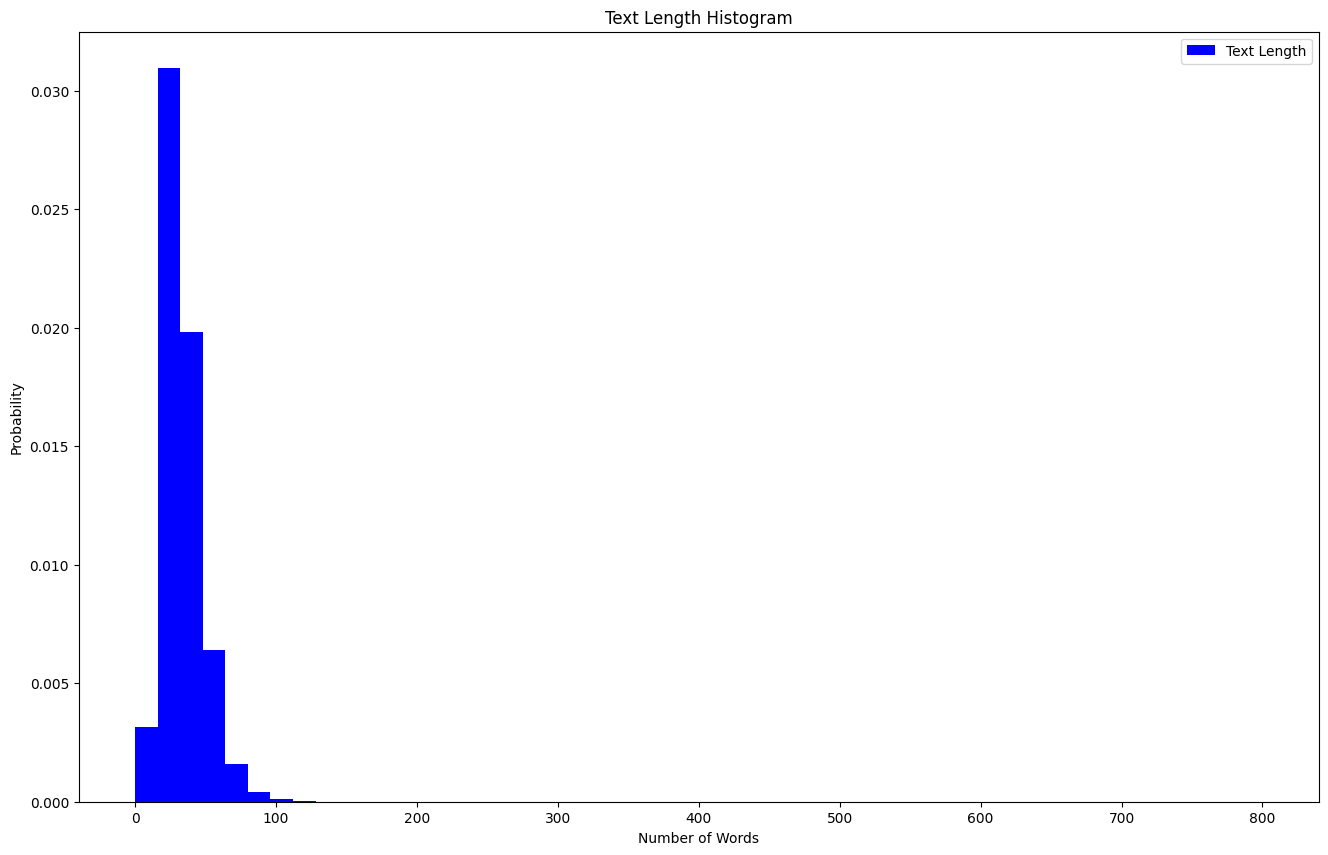

In [ ]:
texts_len = [len(x) for x in texts]

plt.figure(figsize=(16,10))
plt.hist(texts_len, bins=50, range=[0,800], facecolor='b', density=True, label='Text Length')
plt.title('Text Length Histogram')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Probability')

In [ ]:
for tag in list(tag2id.keys()) : 
    globals()[tag] = 0

for tag in tags : 
    for ner in tag : 
        globals()[ner] += 1

for tag in list(tag2id.keys()) : 
    print('{:>6} : {:>7,}'. format(tag, globals()[tag]))

 B-ORG :  32,421
     O : 808,038
 I-ORG : 151,041


## Split

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_tags, test_tags = train_test_split(texts, tags, test_size=.2, random_state=98)

In [ ]:
print('Train Î¨∏Ïû• : {:>6,}' .format(len(train_texts)))
print('Train ÌÉúÍ∑∏ : {:>6,}' .format(len(train_tags)))
print('Test  Î¨∏Ïû• : {:>6,}' .format(len(test_texts)))
print('Test  ÌÉúÍ∑∏ : {:>6,}' .format(len(test_tags)))

Train Î¨∏Ïû• : 24,195
Train ÌÉúÍ∑∏ : 24,195
Test  Î¨∏Ïû• :  6,049
Test  ÌÉúÍ∑∏ :  6,049


## Tokenizing

In [ ]:
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

In [ ]:
# Í∏∞Ï°¥ ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÎäî wordPiece tokenizerÎ°ú tokenizing Í≤∞Í≥ºÎ•º Î∞òÌôòÌï©ÎãàÎã§.
# Îç∞Ïù¥ÌÑ∞ Îã®ÏúÑÎ•º ÏùåÏ†à Îã®ÏúÑÎ°ú Î≥ÄÍ≤ΩÌñàÍ∏∞ ÎïåÎ¨∏Ïóê, tokenizerÎèÑ ÏùåÏ†à tokenizerÎ°ú Î∞îÍøîÏ§òÏïºÌï®

# berttokenizerÎ•º Ïì∏Í±¥Îç∞ Ïó¨Í∏∞Ïóê Îì§Ïñ¥ÏûàÎäî 8000Í∞ú Î∞ñÏóê ÏïàÎêòÎäî ÌïúÍµ≠Ïñ¥Í∞Ä Îì§Ïñ¥ÏûàÏßÄÎßå ÎßéÏùÄÏàòÍ∞Ä ÏùåÏ†àÏù¥Îã§.
# ÌïúÍµ≠Ïñ¥Îì§Ïùò Í±∞Ïùò ÏùåÏ†àÎ°ú Ï°¥Ïû¨. -> ÏùåÏ†à Îã®ÏúÑ tokenizerÎ•º Ï†ÅÏö©Ìï¥ÎèÑ vocab idÎ•º Ïñ¥Îäê Ï†ïÎèÑ ÌöçÎìùÌï† Ïàò ÏûàÏùå.
# Í∑∏ÎûòÏÑú ÏùåÏ†àÎ°ú Ï™ºÍ∞úÎ©¥ UNKÍ∞Ä Î≥ÑÎ°ú ÏóÜÏùÑ Í≤ÉÏù¥Îã§.

def ner_tokenizer(sent, max_seq_length):    
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # Ï§ëÍ∞Ñ ÏùåÏ†àÏóêÎäî Î™®Îëê prefixÎ•º Î∂ôÏûÖÎãàÎã§.
            # Ïö∞Î¶¨Í∞Ä Íµ¨ÏÑ±Ìïú ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÎèÑ Ïù¥Î†áÍ≤å Íµ¨ÏÑ±ÎêòÏóàÍ∏∞ ÎïåÎ¨∏Ïù¥ÎùºÍ≥† Ìï®.
            # Ïù¥ÏàúÏã†ÏùÄ Ï°∞ÏÑ† -> [Ïù¥, ##Ïàú, ##Ïã†, ##ÏùÄ, Ï°∞, ##ÏÑ†]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1
    
    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [ ]:
print(train_texts[0])
print('='*40)
print(ner_tokenizer(train_texts[0], 5))
# 'token_type_ids': [0, 0, 0, 0, 0] ÏùÄ segmentAÎ°ú 0000ÏúºÎ°ú ÎêòÏñ¥ÏûàÎäîÍ±∞.

['ÏïÑ', 'Î≤Ñ', 'ÏßÄ', 'Í∞Ä', '_', 'ÏÇº', 'Ìíç', 'Ïù∏', 'ÌÖå', 'Î¶¨', 'Ïñ¥', '_', 'Ïïº', 'Íµ¨', '_', 'Í≤Ω', 'Í∏∞', '_', 'V', 'I', 'P', '_', 'Ìã∞', 'Ïºì', 'ÏùÑ', '_', 'ÏÉÄ', 'Ïñ¥', '?']
{'input_ids': [2, 2469, 4133, 4044, 3], 'attention_mask': [1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0]}


In [ ]:
tokenized_train_sentences = []
tokenized_test_sentences = []

for text in train_texts:    # Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î•º tokenizing Ìï©ÎãàÎã§.
    tokenized_train_sentences.append(ner_tokenizer(text, 128))
for text in test_texts:
    tokenized_test_sentences.append(ner_tokenizer(text, 128))

In [ ]:
# Ïö∞Î¶¨Ïùò labelÎèÑ truncationÍ≥º tokenizingÏù¥ ÌïÑÏöîÌïòÎã§.
def encode_tags(tags, max_seq_length):
    # label Ïó≠Ïãú ÏûÖÎ†• tokenÍ≥º Í∞úÏàòÎ•º ÎßûÏ∂∞Ï§çÎãàÎã§
    tags = tags[:max_seq_length-2]
    labels = [tag2id[tag] for tag in tags]
    labels = [tag2id['O']] + labels

    padding_length = max_seq_length - len(labels)
    labels = labels + ([pad_token_label_id] * padding_length)

    return labels

In [ ]:
encode_tags(train_tags[0], 5)

[1, 1, 1, 1, 1]

In [ ]:
train_labels = []
test_labels = []

for tag in train_tags:
    train_labels.append(encode_tags(tag, 128))

for tag in test_tags:
    test_labels.append(encode_tags(tag, 128))

In [ ]:
len(train_labels), len(test_labels)

(24195, 6049)

In [ ]:
class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TokenDataset(tokenized_train_sentences, train_labels)
test_dataset = TokenDataset(tokenized_test_sentences, test_labels)

In [ ]:
from transformers import BertForTokenClassification, Trainer, TrainingArguments, AutoModelForTokenClassification,EarlyStoppingCallback
import sys
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1000, # 1000Î≤àÏ®∞ stepsÎßàÎã§ logÎ•º Î≥¥Ïó¨Ï§å 
    learning_rate=3e-5,
    weight_decay=0.01,
    save_total_limit=5,
    save_strategy='steps', # stepsÎ°ú Ìï¥Ïïº earlystopÏù¥ Í∞ÄÎä•
    evaluation_strategy='steps',
    save_steps=1000, # 1000Î≤àÏ®∞ stepÎßàÎã§ Ï†ÄÏû•
    eval_steps=1000, # 1000Î≤àÏß∏ stepÎßàÎã§ ÌèâÍ∞Ä
    seed=15,
    load_best_model_at_end=True # Í∞ÄÏû• Ï¢ãÏùÄ ÏÑ±Îä•Ïùò Î™®Îç∏Î°ú...
)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags))
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated ü§ó Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,# evaluation dataset
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] #lossÍ∞Ä 2Î≤à Í∞êÏÜåÌïòÏßÄ ÏïäÏúºÎ©¥ Ïä§ÌÉë
)

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']

In [ ]:
import gc
gc.collect()

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=8000, training_loss=0.00594474145770073, metrics={'train_runtime': 2120.6217, 'train_samples_per_second': 57.047, 'train_steps_per_second': 7.132, 'total_flos': 4180132657866240.0, 'train_loss': 0.00594474145770073, 'epoch': 2.64})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.004557328298687935,
 'eval_runtime': 43.5554,
 'eval_samples_per_second': 138.881,
 'eval_steps_per_second': 2.181,
 'epoch': 2.64}

In [ ]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(6049, 128, 3) (6049, 128)


In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
index_to_ner = {i:j for j, i in tag2id.items()}
f_label = [i for i, j in tag2id.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(predictions.label_ids).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(preds).astype(int).tolist()]

In [ ]:
#Îç∞Ïù¥ÌÑ∞ÏÖã Ï∂îÍ∞Ä
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

       B-ORG       0.98      0.97      0.98      6518
           O       1.00      1.00      1.00    737289
       I-ORG       0.98      0.99      0.99     30465

    accuracy                           1.00    774272
   macro avg       0.99      0.99      0.99    774272
weighted avg       1.00      1.00      1.00    774272



In [ ]:
trainer.save_model('kcelectra_base_new')

## ÌïôÏäµ ÌõÑ Í≤∞Í≥º ÌôïÏù∏

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('kcelectra_base_new', num_labels=len(unique_tags))
model.to(device)

ElectraForTokenClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [ ]:
def ner_inference(text) : 
  
    model.eval()
    text = text.replace(' ', '_')

    predictions , true_labels = [], []
    
    tokenized_sent = ner_tokenizer(text, len(text)+2)
    input_ids = torch.tensor(tokenized_sent['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokenized_sent['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(tokenized_sent['token_type_ids']).unsqueeze(0).to(device)    
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
    logits = outputs['logits']
    logits = logits.detach().cpu().numpy()
    label_ids = token_type_ids.cpu().numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)

    pred_tags = [list(tag2id.keys())[p_i] for p in predictions for p_i in p]

    print('{}\t{}'.format("TOKEN", "TAG"))
    print("===========")
    # for token, tag in zip(tokenizer.decode(tokenized_sent['input_ids']), pred_tags):
    #   print("{:^5}\t{:^5}".format(token, tag))
    for i, tag in enumerate(pred_tags):
        print("{:^5}\t{:^5}".format(tokenizer.convert_ids_to_tokens(tokenized_sent['input_ids'][i]), tag))

In [ ]:
text = 'ÌåùÍ∞ÄÍ∞Ä ÎØ∏Î¶¨ ÏïåÎ†§Ï£ºÎäî ÏóÖÏª§Î∞ç ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Ìè¨ÏºìÎ™¨ Ïä§ÌîÑÎßÅ ÌéòÏä§ÌÉÄ in Î°ØÎç∞ÏõîÎìúÎ™∞ 2023 04.28(Í∏à)-05.08(Ïõî) ÏÜ°ÌååÍµ¨ Ïò¨Î¶ºÌîΩÎ°ú 300, Î°ØÎç∞ÏõîÎìúÎ™∞ & ÏõîÎìúÌååÌÅ¨ Îß§Ïùº: 10:30~22:00 Ìè¨ÏºìÎ™¨Í≥º Ìï®Íªò Î™®ÌóòÏùÑ Îñ†ÎÇ† Ïñ¥Î¶∞&Ïñ¥Î•∏Ïù¥Îì§ Îã§ Î™®Ïó¨Îùº-** ** Î¥ÑÎßûÏù¥ Ìè¨ÏºìÎ™¨ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ Í∞Ä Ïû†Ïã§ Î°ØÎç∞ÏõîÎìúÎ™∞ Í≥≥Í≥≥ÏóêÏÑú ÏßÑÌñâÎê† ÏòàÏ†ïÏù¥Ïïº! Ìè¨ÏºìÎ™¨ Ï∫êÎ¶≠ÌÑ∞ Î¥âÏ†ú Ïù∏Ìòï, Ïä§Ìã∞Ïª§, ÌïÑÍ∏∞Íµ¨ Îì± Í∑ÄÏó¨Ïö¥ ÍµøÏ¶àÏôÄ ÎåÄÌòï Ìè¨ÌÜ†Ï°¥ÏùÑ Ìè¨Ìï®Ìïú Îã§Ï±ÑÎ°úÏö¥ Ï≤¥Ìóò Í±∞Î¶¨Î•º ÌïúÏûêÎ¶¨ÏóêÏÑú ÎßåÎÇòÎ≥º Ïàò ÏûàÎåÄ! Ìè¨ÏºìÎ™¨ Ïï†ÎãàÎ©îÏù¥ÏÖò & Í∑πÏû•Ìåê Ïª®ÏÖâÏùò ÎåÄÍ∑úÎ™® Ìè¨ÌÜ†Ï°¥ (Î°ØÎç∞ÏõîÎìúÎ™∞ ÏïºÏô∏Í¥ëÏû•) Íµ≠ÎÇ¥ ÏµúÏ¥à Ìè¨ÏºìÎ™¨ Ïπ¥Îìú Í∞§Îü¨Î¶¨ (Î°ØÎç∞ÏõîÎìúÎ™∞ 5Ï∏µ ÏïÑÏù¥ÏΩîÎãâ Î∏åÎ¶øÏßÄ) Ìè¨ÏºìÎ™¨ Ïä§ÏπºÎ†õ & Î∞îÏù¥Ïò¨Î†õ Î∞∞ÌãÄ Ï≤¥Ìóò Ïù¥Î≤§Ìä∏ (Î°ØÎç∞ÏõîÎìúÎ™∞ 4Ï∏µ ÌÇ§Ï¶àÌîåÎ°úÏñ¥) Ìè¨ÏºìÎ™¨ ÌåùÏóÖÏä§ÌÜ†Ïñ¥Îäî ÌòÑÏû• Î∞©Î¨∏ ÏòàÏïΩÏ†úÎ°ú Ïö¥ÏòÅÎêòÎãà Ï∞∏Í≥†Ìï¥ Ïù¥Î≤à Ï£º, Í∏àÏöîÏùº Ìè¨ÏºìÎ™¨ ÌåùÏóÖÏä§ÌÜ†Ïñ¥Î°ú Îã¨Î†§Í∞Ä Î≥¥ÏûêÍµ¨ ÏôºÏ™Ω ÌïòÎã®ÏùÑ ÎàåÎü¨ ÌåùÏóÖÏä§ÌÜ†Ïñ¥ ÏïåÎ¶º Ïã†Ï≤≠ÌïòÍ≥† ÎÜìÏπòÏßÄ ÎßêÏûê!'

ner_inference(text)

TOKEN	TAG
[CLS]	  O  
  Ìåù  	  O  
 ##Í∞Ä 	  O  
 ##Í∞Ä 	  O  
  _  	  O  
  ÎØ∏  	  O  
 ##Î¶¨ 	  O  
  _  	  O  
  Ïïå  	  O  
 ##Î†§ 	  O  
 ##Ï£º 	  O  
 ##Îäî 	  O  
  _  	  O  
  ÏóÖ  	  O  
 ##Ïª§ 	  O  
 ##Î∞ç 	  O  
  _  	  O  
  Ìåù  	  O  
 ##ÏóÖ 	  O  
 ##Ïä§ 	  O  
 ##ÌÜ† 	  O  
 ##Ïñ¥ 	  O  
  _  	  O  
  Ìè¨  	  O  
 ##Ïºì 	  O  
 ##Î™¨ 	  O  
  _  	  O  
  Ïä§  	  O  
 ##ÌîÑ 	  O  
 ##ÎßÅ 	  O  
  _  	  O  
  Ìéò  	  O  
 ##Ïä§ 	  O  
 ##ÌÉÄ 	  O  
  _  	  O  
  i  	  O  
 ##n 	  O  
  _  	  O  
  Î°Ø  	  O  
 ##Îç∞ 	  O  
 ##Ïõî 	  O  
 ##Îìú 	  O  
 ##Î™∞ 	  O  
  _  	  O  
  2  	  O  
 ##0 	  O  
 ##2 	  O  
 ##3 	  O  
  _  	  O  
  0  	  O  
 ##4 	  O  
[UNK]	  O  
 ##2 	  O  
 ##8 	  O  
[UNK]	  O  
 ##Í∏à 	  O  
[UNK]	  O  
[UNK]	  O  
 ##0 	  O  
 ##5 	  O  
[UNK]	  O  
 ##0 	  O  
 ##8 	  O  
[UNK]	  O  
 ##Ïõî 	  O  
[UNK]	  O  
  _  	  O  
  ÏÜ°  	  O  
 ##Ìåå 	  O  
 ##Íµ¨ 	I-ORG
  _  	  O  
  Ïò¨  	  O  
 ##Î¶º 	  O  
 ##ÌîΩ 	  O  
 ##Î°ú 	  O  
  _  	  O 

# ÎåÄ Ïã§ Ìå® !